In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from scipy.stats import beta
from scipy.stats import norm

In [2]:
def get_season(month):
    """Maps month number to Northern Hemisphere seasons."""
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

Getting training set

In [3]:
df = pd.read_csv(
    "Wind_Fin_2015_24.csv",
    sep=';',
    encoding='utf-8',          
    encoding_errors='ignore'
)
# Convert timestamps ---
df['startTime'] = pd.to_datetime(df['startTime'])
df['endTime'] = pd.to_datetime(df['endTime'])

df['Month'] = df['startTime'].dt.month
df['Season'] = df['Month'].apply(get_season)
df['Year'] = df['startTime'].dt.year
df['day and month'] = df['startTime'].dt.strftime('%d-%m')
df['Hour'] = df['startTime'].dt.hour

# Rename generation column ---
df.rename(columns={"Wind power generation - 15 min data": "generation"}, inplace=True)

#take only up to year 2024 
df_train = df[df['Year'] <= 2023]

# Convert generation to numeric (important step!)
df_train['generation'] = pd.to_numeric(df_train['generation'], errors='coerce')
median_power = df_train['generation'].median()
df_train['generation'].fillna(median_power, inplace=True)

# --- normalization ---
scaler = MinMaxScaler()
df_train['Norm_gen'] = np.nan # Initialize the final column
# The loop structure below completes the Annual Normalization
for year, group_data in df_train.groupby('Year'):
    
    # Select the generation data for the current year
    data_to_scale = group_data['generation'].values.reshape(-1, 1)
    
    # Scale the data based on the max/min of that specific year
    scaled_data = scaler.fit_transform(data_to_scale)
    
    # Apply the scaled data back to the original DataFrame for that year
    df_train.loc[df_train['Year'] == year, 'Norm_gen'] = scaled_data.flatten()


# Group by both Year and Season for the most granular bounds
annual_seasonal_groups = df_train.groupby(['Year', 'Season'])
total_capped = 0
bound_summary = []

for (year, season_name), group_data in annual_seasonal_groups:
    
    # Calculate IQR and bounds specific to this YEAR-SEASON group on Norm_gen
    Q1 = group_data['Norm_gen'].quantile(0.25)
    Q3 = group_data['Norm_gen'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    lower_outliers = group_data[group_data['Norm_gen'] < lower_bound].shape[0]
    upper_outliers = group_data[group_data['Norm_gen'] > upper_bound].shape[0]
    
    total_capped += lower_outliers + upper_outliers
    
    # Apply capping (Winsorizing) directly to the Norm_gen column in the main DataFrame
    condition = (df_train['Year'] == year) & (df_train['Season'] == season_name)
    df_train.loc[condition & (df_train['Norm_gen'] < lower_bound), 'Norm_gen'] = lower_bound
    df_train.loc[condition & (df_train['Norm_gen'] > upper_bound), 'Norm_gen'] = upper_bound

print(f"Total rows capped across all Year-Season groups: {total_capped}")

C:\Users\Gloria\AppData\Local\Temp\ipykernel_39148\2310493523.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['generation'] = pd.to_numeric(df_train['generation'], errors='coerce')
C:\Users\Gloria\AppData\Local\Temp\ipykernel_39148\2310493523.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the

Total rows capped across all Year-Season groups: 790


C:\Users\Gloria\AppData\Local\Temp\ipykernel_39148\1545206676.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df_train[(df_train["Season"] == s) & (df["Hour"] == h)]
C:\Users\Gloria\AppData\Local\Temp\ipykernel_39148\1545206676.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df_train[(df_train["Season"] == s) & (df["Hour"] == h)]
C:\Users\Gloria\AppData\Local\Temp\ipykernel_39148\1545206676.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df_train[(df_train["Season"] == s) & (df["Hour"] == h)]
C:\Users\Gloria\AppData\Local\Temp\ipykernel_39148\1545206676.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df_train[(df_train["Season"] == s) & (df["Hour"] == h)]


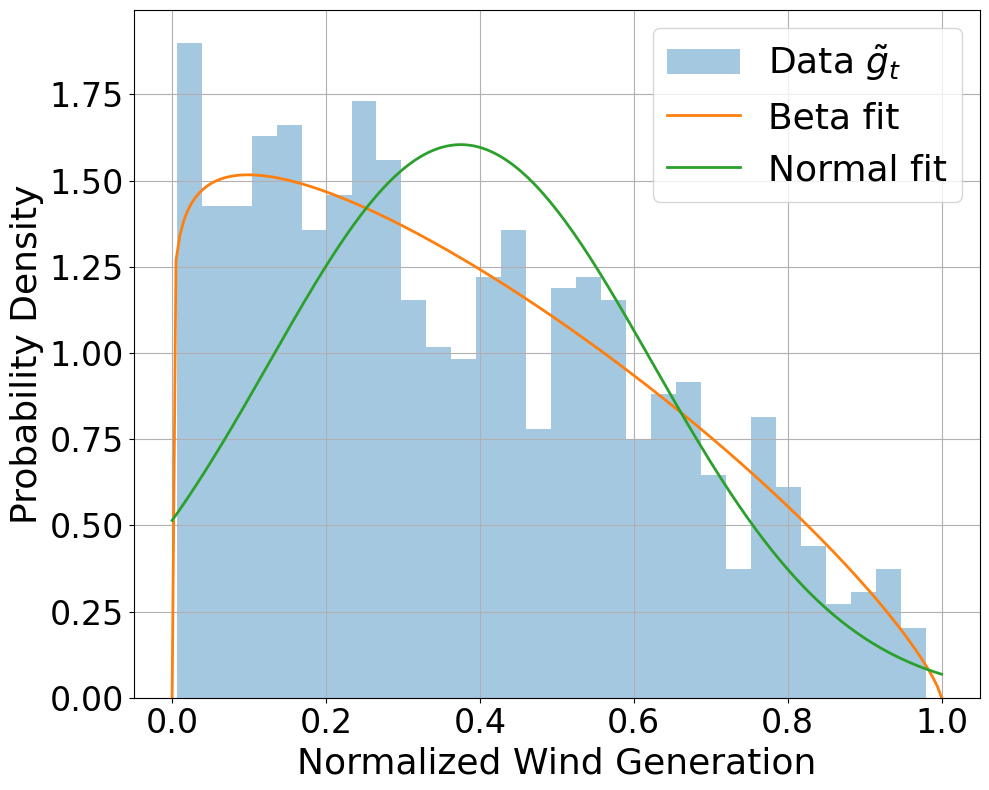

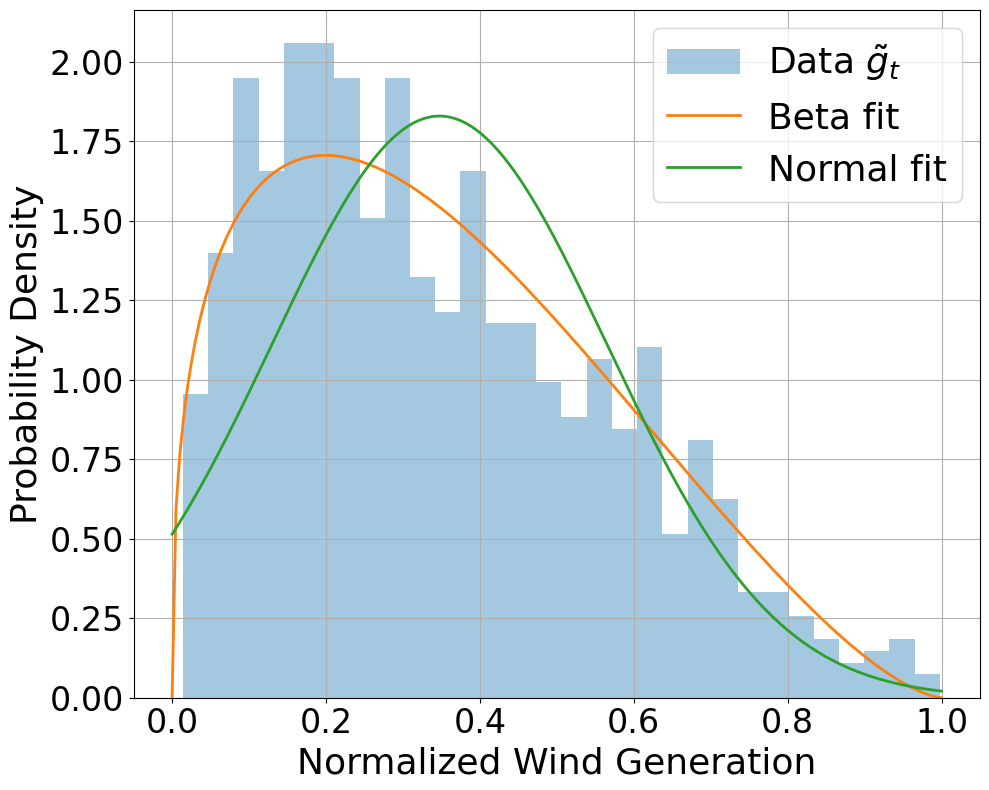

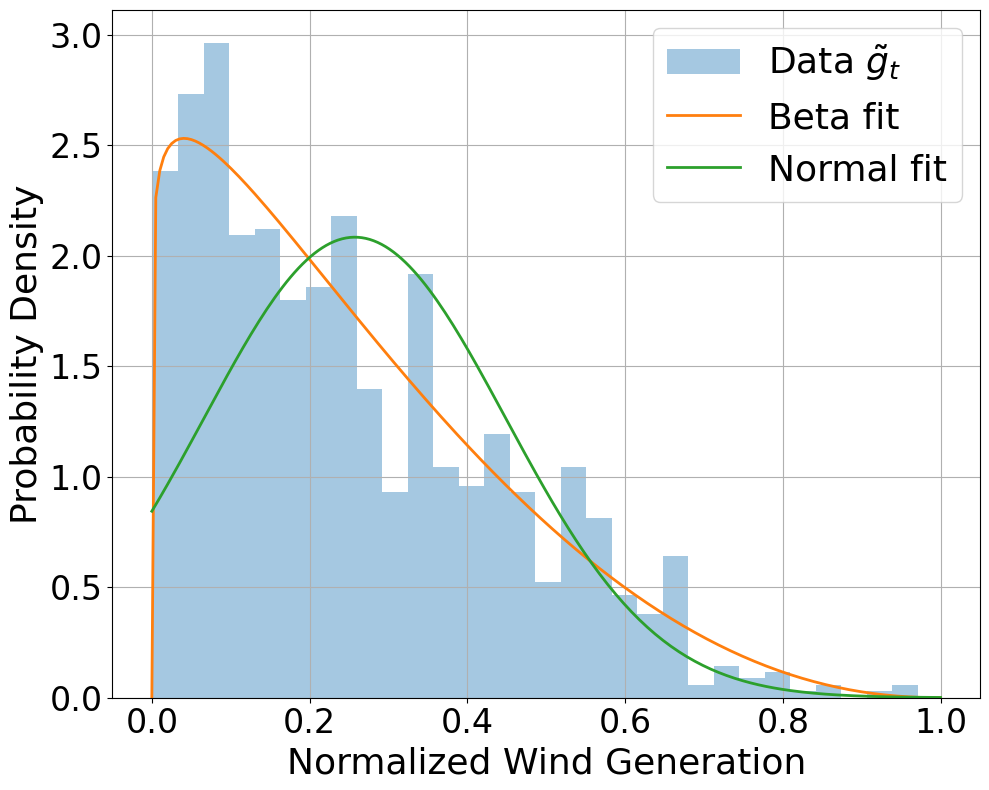

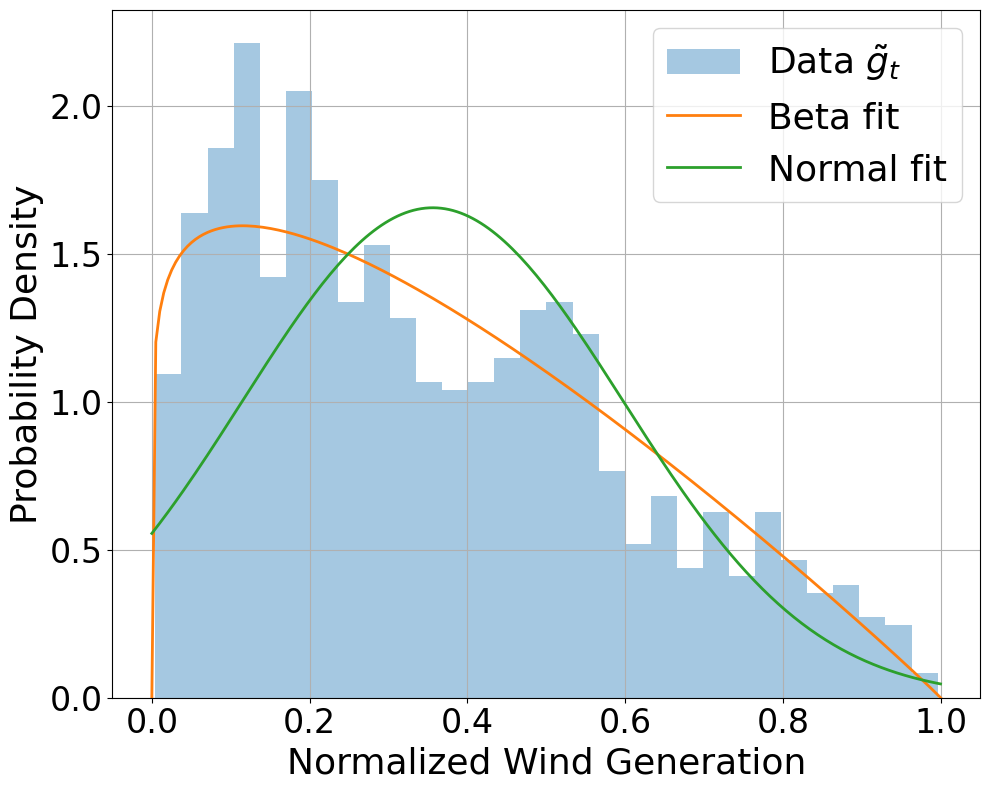

In [14]:
for s in ["Winter", "Spring", "Summer", "Autumn"]:
    for h in range(1):
        subset = df_train[(df_train["Season"] == s) & (df["Hour"] == h)]
        x = subset["Norm_gen"].dropna().values
        
        # Beta
        x = np.clip(x, 1e-4, 1-1e-4)
        a, b, _, _ = beta.fit(x, floc=0, fscale=1)

        #empirical CDF
        ecdf = np.sort(x)

        mu, sigma = x.mean(), x.std()
        a_t, b_t = (0 - mu)/sigma, (1 - mu)/sigma

        xs = np.linspace(0, 1, 200)

        #normal distribution
        mu, sigma = norm.fit(x)

        #plot to compare 
        plt.figure(figsize=(10,8))   # set figure size here
        plt.hist(x, bins=30, density=True, alpha=0.4, label=rf"Data $\tilde{{g}}_t$")
        plt.plot(xs, beta.pdf(xs, a, b), label="Beta fit", lw=2)
        #plt.plot(xs, truncnorm.pdf(xs, a_t, b_t, mu, sigma),
        #        label="TruncNorm", lw=2)
        plt.plot(xs, norm.pdf(xs, mu, sigma), label="Normal fit", lw=2)
        plt.xlabel("Normalized Wind Generation", fontsize = 26)
        plt.ylabel("Probability Density", fontsize = 26)
        plt.legend(fontsize = 26)
        #plt.title(rf"{s} - hour $t = {h}$", fontsize = 18)
        plt.xticks(fontsize = 24)
        plt.yticks(fontsize = 24)
        plt.grid(True)
        plt.tight_layout()
        #plt.show()
        plt.savefig(rf"../../Figures/Forecast/Wind_dist_{s}_hour_{h}.pdf")

Getting testing set

In [5]:
df_test = df[(df['Year'] >= 2024)]

# Convert generation to numeric (important step!)
df_test['generation'] = pd.to_numeric(df_test['generation'], errors='coerce')
median_power = df_test['generation'].median()
df_test['generation'].fillna(median_power, inplace=True)

# --- normalization ---
scaler = MinMaxScaler()
df_test['Norm_gen'] = np.nan 


for year, group_data in df_test.groupby('Year'):
    
    # Select the generation data for the current year
    data_to_scale = group_data['generation'].values.reshape(-1, 1)
    
    # Scale the data based on the max/min of that specific year
    scaled_data = scaler.fit_transform(data_to_scale)
    
    # Apply the scaled data back to the original DataFrame for that year
    df_test.loc[df_test['Year'] == year, 'Norm_gen'] = scaled_data.flatten()

# Group by both Year and Season for the most granular bounds
annual_seasonal_groups = df_test.groupby(['Year', 'Season'])
total_capped = 0
bound_summary = []

for (year, season_name), group_data in annual_seasonal_groups:
    
    # Calculate IQR and bounds specific to this YEAR-SEASON group on Norm_gen
    Q1 = group_data['Norm_gen'].quantile(0.25)
    Q3 = group_data['Norm_gen'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    lower_outliers = group_data[group_data['Norm_gen'] < lower_bound].shape[0]
    upper_outliers = group_data[group_data['Norm_gen'] > upper_bound].shape[0]
    
    total_capped += lower_outliers + upper_outliers
    
    # Apply capping (Winsorizing) directly to the Norm_gen column in the main DataFrame
    condition = (df_test['Year'] == year) & (df_test['Season'] == season_name)
    df_test.loc[condition & (df_test['Norm_gen'] < lower_bound), 'Norm_gen'] = lower_bound
    df_test.loc[condition & (df_test['Norm_gen'] > upper_bound), 'Norm_gen'] = upper_bound

print(f"Total rows capped across all Year-Season groups: {total_capped}")

Total rows capped across all Year-Season groups: 131


C:\Users\Gloria\AppData\Local\Temp\ipykernel_39148\173201446.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['generation'] = pd.to_numeric(df_test['generation'], errors='coerce')
C:\Users\Gloria\AppData\Local\Temp\ipykernel_39148\173201446.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origi

Beta distribution

In [6]:
def build_seasonal_hourly_scenarios_by_std(
    df,
    value_col="Norm_gen",
    season_col="Season",
    hour_col="hour",
    N=80,
    std_factor=1.0,
    eps=1e-4,
):
    """
    For each (season, hour):
      - fit Beta to `value_col`
      - compute mean μ and std σ
      - restrict to [μ - std_factor·σ, μ + std_factor·σ] ∩ (eps,1-eps)
      - build N-point discrete PMF over that interval

    Returns DataFrame with:
      [season, hour, scenario, value, probability]
    """

    records = []

    for (season, hour), g in df.groupby([season_col, hour_col]):
        
        x = g[value_col].dropna().values
        if len(x) == 0:
            continue

        x = np.clip(x, eps, 1 - eps)

        try:
            a, b, _, _ = beta.fit(x, floc=0, fscale=1)

            # mean & std
            mu, var = beta.stats(a, b, moments='mv')
            mu = float(mu)
            sigma = float(np.sqrt(var))

            # interval [L, U] = [μ - kσ, μ + kσ]
            L = mu - std_factor * sigma
            U = mu + std_factor * sigma

            L = max(L, eps)
            U = min(U, 1 - eps)
            if (not np.isfinite(L)) or (not np.isfinite(U)) or L >= U:
                L, U = eps, 1 - eps

            x_vals = np.linspace(L, U, N)
            pdf_vals = beta.pdf(x_vals, a, b)
            pdf_vals = np.where(np.isfinite(pdf_vals), pdf_vals, 0.0)

            if pdf_vals.sum() == 0:
                p_vals = np.ones(N) / N
            else:
                p_vals = pdf_vals / pdf_vals.sum()

        except Exception:
            # fallback: uniform on [eps,1-eps]
            x_vals = np.linspace(eps, 1 - eps, N)
            p_vals = np.ones(N) / N

        for i in range(N):
            records.append({
                "season": season,
                "hour": hour,
                "scenario": i + 1,
                "value": x_vals[i],
                "probability": p_vals[i],
            })

    return pd.DataFrame.from_records(records)

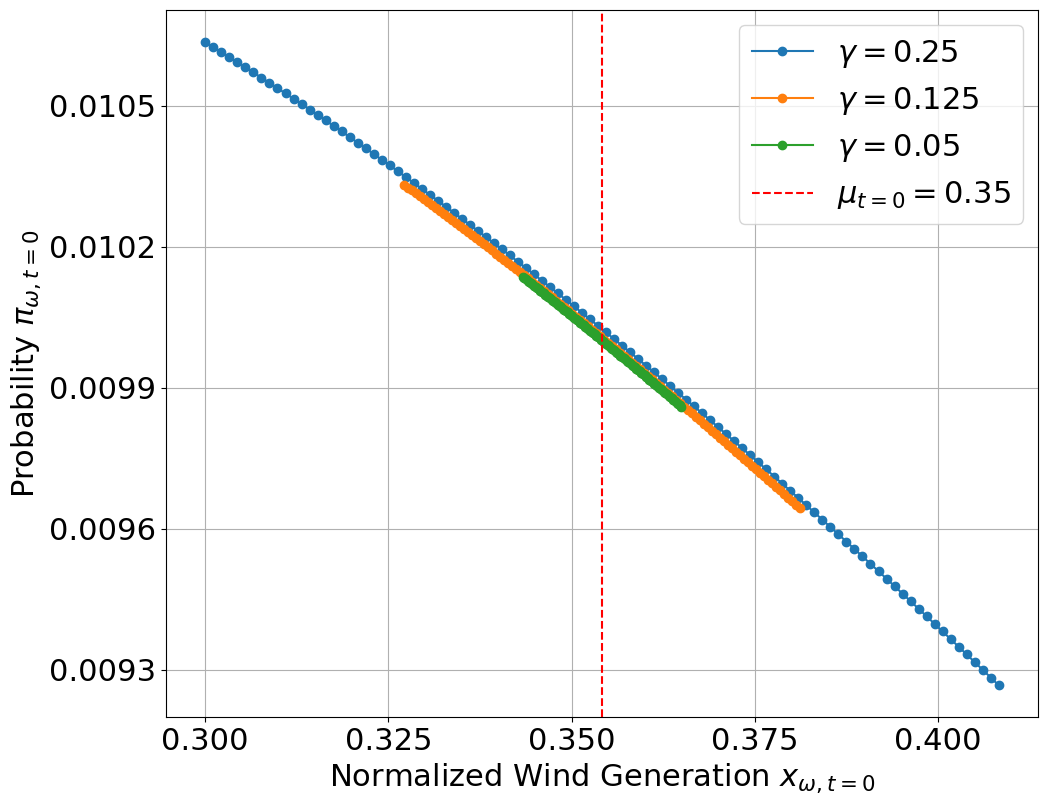

In [17]:
s_005 = build_seasonal_hourly_scenarios_by_std(
    df_train,
    value_col="Norm_gen",
    season_col="Season",
    hour_col="Hour",
    N=100,
    std_factor=0.05,   # mean ± 1.5σ
)

s_0125 = build_seasonal_hourly_scenarios_by_std(
    df_train,
    value_col="Norm_gen",
    season_col="Season",
    hour_col="Hour",
    N=100,
    std_factor=0.125,   # mean ± 1.5σ
)

s_025 = build_seasonal_hourly_scenarios_by_std(
    df_train,
    value_col="Norm_gen",
    season_col="Season",
    hour_col="Hour",
    N=100,
    std_factor=0.25,   # mean ± 1.5σ
)


#plot all of them on the same graph for hour 1 and seaosn spring 
fig = plt.figure(figsize=(10, 8))
hour = 0
season = "Spring"
means = []

for scenarios_df, label in zip(
    [s_025, s_0125, s_005],
    [rf'$\gamma = 0.25$', rf'$\gamma = 0.125$', rf'$\gamma = 0.05$']):
    subset = scenarios_df[
        (scenarios_df['season'] == season) &
        (scenarios_df['hour'] == hour)
    ]
    means.append(np.mean(subset['value']))
    plt.plot(
        subset['value'],
        subset['probability'],
        marker='o',
        linestyle='-',
        label=label
    )

plt.axvline(means[0], linestyle = '--', label = rf'$\mu_{{t={hour}}} = {round(means[0],2)}$', color='red')
plt.xlabel(rf"Normalized Wind Generation $x_{{\omega, t = {hour}}}$", fontsize = 22)
plt.ylabel(rf"Probability $\pi_{{\omega, t = {hour}}}$", fontsize = 22)
#plt.title(rf"Discrete sample scenarios, {season} - hour $t ={hour}$", fontsize = 18)

plt.grid(True)
plt.tight_layout()
plt.legend(fontsize = 22)

#plt.xlim(0.2, 0.4)
from matplotlib.ticker import MaxNLocator
plt.xticks(np.linspace(0.30, 0.40, 5), fontsize = 22)  # 0, 2, 4, 6, 8, 10
plt.yticks(fontsize = 22)
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
ax.ticklabel_format(axis='y', style='plain', scilimits=(0, 0))
ax.yaxis.get_offset_text().set_fontsize(22)
plt.show()
fig.savefig(rf"../../Figures/Forecast/k_tunning.pdf", bbox_inches="tight")

Mean Normalized Generation for Spring Hour 1 in testing years: 0.3295
Beta Expected Value for Spring Hour 1: 0.3512
Beta Expected Value (formula) for Spring Hour 1: 0.3512


C:\Users\Gloria\AppData\Local\Temp\ipykernel_22904\2181755102.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['seasonal_date'] = pd.to_datetime(


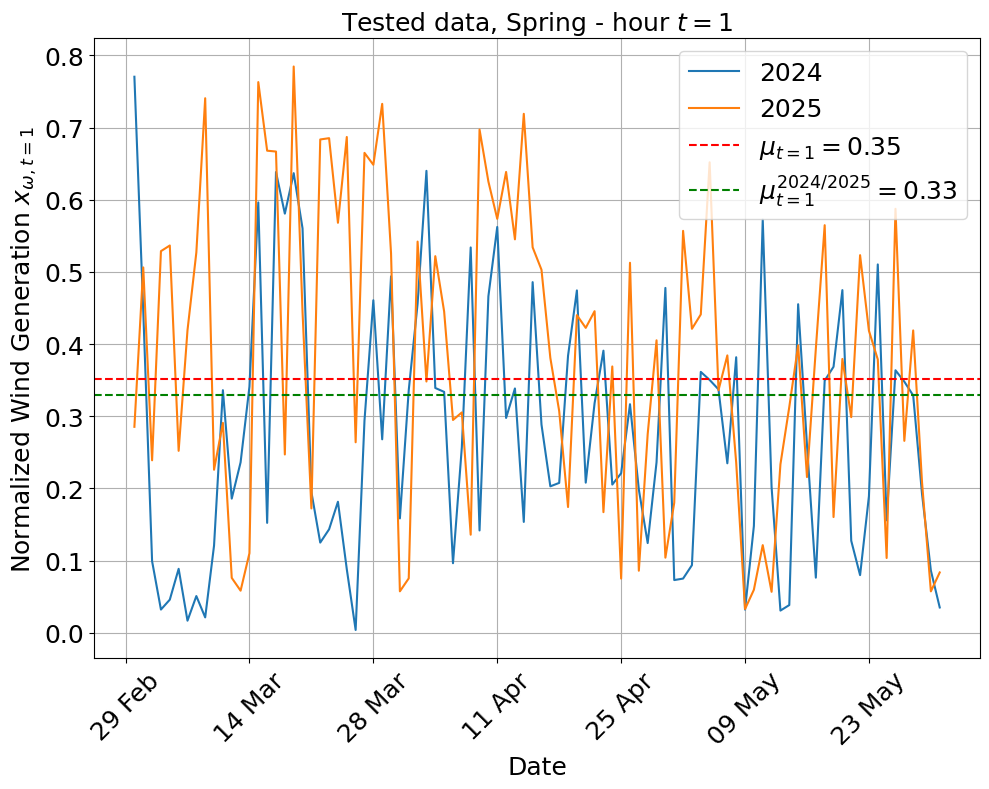

<Figure size 640x480 with 0 Axes>

In [20]:
#calculate mean of normalized generation for spring hour 1 in 2025
mean_2024_25 = df_test[(df_test['Season'] == "Spring") & (df_test['Hour'] == 0)]['Norm_gen'].mean()
print(f"Mean Normalized Generation for Spring Hour 1 in testing years: {mean_2024_25:.4f}")

#check the expected value of weibull scenarios with the values obtained for 2025, just for spring hour 1
subset = df_train[(df_train["Season"] == "Spring") & (df_train["Hour"] == 1)]
x = subset["Norm_gen"].dropna().values
x = np.clip(x, 1e-4, 1-1e-4)

#check the expected value of beta scenarios with the values obtained for training datat, just for spring hour 1
a_beta, b_beta, _, _ = beta.fit(x, floc=0, fscale=1)
mean_beta = beta.mean(a_beta, b_beta, loc=0, scale=1)
expected = a_beta / (a_beta + b_beta)
print(f"Beta Expected Value for Spring Hour 1: {mean_beta:.4f}")
print(f"Beta Expected Value (formula) for Spring Hour 1: {expected:.4f}")

REF_YEAR = 2000
df_test['seasonal_date'] = pd.to_datetime(
    str(REF_YEAR) + '-' + df_test['day and month'],
    format='%Y-%d-%m'
)

### create a plot that show all of the data for season spring and hour 1 for years 2025 and show expected value from weibull 
import seaborn as sns
import matplotlib.dates as mdates

plt.figure(figsize=(10, 8))
sns.lineplot(data=df_test[(df_test['Year'] == 2024) & (df_test['Season'] == "Spring") & (df_test['Hour'] == 0)], x='seasonal_date', y='Norm_gen', label="2024", errorbar=None)
sns.lineplot(data=df_test[(df_test['Year'] == 2025) & (df_test['Season'] == "Spring") & (df_test['Hour'] == 0)], x='seasonal_date', y='Norm_gen', label="2025", errorbar=None)
plt.axhline(y=mean_beta, color='r', linestyle='--', label=rf'$\mu_{{t=1}} = {round(mean_beta,2)}$')
plt.axhline(y=mean_2024_25, color='g', linestyle='--', label=rf'$\mu_{{t=1}}^{{2024/2025}} = {round(mean_2024_25,2)}$')
ax = plt.gca()

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

plt.title(rf"Tested data, Spring - hour $t = 1$", fontsize = 18)
plt.xlabel("Date", fontsize=18)
plt.ylabel(rf"Normalized Wind Generation $x_{{\omega, t=1}}$", fontsize = 18)

plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig(rf"../../Figures/tested_data.pdf")

In [21]:
#save scenarios to csv
s_005.to_csv("seasonal_scenarios_005.csv", index=False)
s_0125.to_csv("seasonal_scenarios_0125.csv", index=False)
s_025.to_csv("seasonal_scenarios_025.csv", index=False)